In [57]:
from typing import List, Tuple, Any, Dict
from copy import deepcopy
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.models as torch_models
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader, Dataset

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.benchmark = False

# def init_seed():
#     torch.manual_seed(4321)

NVIDIA GeForce RTX 3080


## Prepare Dataset

In [56]:
class RetinopathyDataset(Dataset):
    _root_dir: str
    _image_names: np.ndarray
    _labels: np.ndarray
    _transforms: transforms.Compose

    def __init__(
        self, root_dir: str, image_csv: str, label_csv: str
    ):
        super(RetinopathyDataset, self).__init__()
        if not os.path.exists(image_csv):
            raise FileNotFoundError(f"The csv file {image_csv} does not exist.")
        if not os.path.exists(label_csv):
            raise FileNotFoundError(f"The csv file {label_csv} does not exist.")
        if not os.path.exists(root_dir):
            raise FileNotFoundError(f"The folder {root_dir} does not exist.")

        self._root_dir = root_dir
        self._image_names = np.squeeze(pd.read_csv(image_csv).values)
        self._labels = np.squeeze(pd.read_csv(label_csv).values)
        self._transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return self._image_names.shape[0]

    def __getitem__(self, index: int):
        """something you should implement here
            step1. Get the image path from 'self.img_name' and load it.
                hint : path = root + self.img_name[index] + '.jpeg'

            step2. Get the ground truth label from self.label

            step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping, 
                rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints. 

                In the testing phase, if you have a normalization process during the training phase, you only need 
                to normalize the data. 

                hints : Convert the pixel value to [0, 1]
                        Transpose the image shape from [H, W, C] to [C, H, W]

            step4. Return processed image and label
        """
        path = self._root_dir + "/" + self._image_names[index] + ".jpeg"
        image = self._transforms(Image.open(path))
        return image, self._labels[index]

train_dataset = RetinopathyDataset(root_dir = "data", image_csv = "train_img.csv", label_csv = "train_label.csv")
test_dataset = RetinopathyDataset(root_dir = "data", image_csv = "test_img.csv", label_csv = "test_label.csv")

## Build Models

In [53]:
class ResNet18(nn.Module):
    model: nn.Module
    def __init__(self, out_features, pretrained = True, feature_extracting = False):
        super(ResNet18, self).__init__()

        self.model = torch_models.resnet18(weights = torch_models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        # freeze pretrained layers
        if pretrained and feature_extracting:
            for param in self.model.parameters():
                param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, out_features)

    def forward(self, x):
        return self.model(x)

class ResNet50(nn.Module):
    model: nn.Module
    def __init__(self, out_features, pretrained = True, feature_extracting = False):
        super(ResNet50, self).__init__()

        self.model = torch_models.resnet50(weights = torch_models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
        # freeze pretrained layers
        if pretrained and feature_extracting:
            for param in self.model.parameters():
                param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, out_features)

    def forward(self, x):
        return self.model(x)

## Training & Testing

In [54]:
class Trainer:
    _device: str
    _criterion: nn.Module
    _train_dataloader: DataLoader
    _test_dataloader: DataLoader

    _models_metrics: Dict[str, Dict[str, Any]]

    def __init__(
        self, criterion: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader
    ):
        self._device = "cuda" if torch.cuda.is_available() else "cpu"
        self._criterion = criterion
        self._train_dataloader = train_dataloader
        self._test_dataloader = test_dataloader

        self._models_metrics = {}

    @staticmethod
    def _calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
        return torch.sum(torch.argmax(y_pred, dim = 1) == y_true, dtype = torch.int).item()

    def _show_loss(self, epoch_size: int):
        epochs = list(range(1, epoch_size + 1))
        accuracy_histories = {name: metrics["loss_history"] for name, metrics in self._models_metrics.items()}

        plt.figure(figsize=(12, 6))
        plt.title("Train loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        for name, loss_history in accuracy_histories.items():
            train_loss_list = loss_history["train"]
            test_loss_list = loss_history["test"]
            plt.plot(epochs, train_loss_list, label = f"{name}_train")
            plt.plot(epochs, test_loss_list, label = f"{name}_test")
        plt.legend()
        plt.show()

    def _show_accuracy(self, epoch_size: int):
        epochs = list(range(1, epoch_size + 1))
        accuracy_histories = {name: metrics["accuracy_history"] for name, metrics in self._models_metrics.items()}
        best_test_accuracy_dict = {name: metrics["best_test_accuracy"] for name, metrics in self._models_metrics.items()}

        plt.figure(figsize=(12, 6))
        plt.title(f"Activation function comparison")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy(%)")
        for name, accuracy_history in accuracy_histories.items():
            train_accuracy_list = accuracy_history["train"]
            test_accuracy_list = accuracy_history["test"]
            plt.plot(epochs, np.array(train_accuracy_list) * 100, label = f"{name}_train")
            plt.plot(epochs, np.array(test_accuracy_list) * 100, label = f"{name}_test")
        plt.legend()
        plt.show()

        for name, accuracy in best_test_accuracy_dict.items():
            print(f"{name}'s best accuracy: {accuracy}")

    def _save_weights(self, folder_path: str):
        for name, metrics in self._models_metrics.items():
            weights = metrics["best_model_weights"]
            epoch = metrics["best_epoch"]
            torch.save(weights, folder_path + "/" + f"{name}_epoch_{epoch}.pth")

    def _add_metrics(self, models: Dict[str, nn.Module]):
        for name, model in models.items():
            tmp = {
                "accuracy_history": {
                    "train": [],
                    "test": []
                },
                "loss_history": {
                    "train": [],
                    "test": []
                },
                "best_epoch": -1,
                "best_test_accuracy": 0,
                "best_model_weights": None
            }
            self._models_metrics[name] = tmp

    def clear_metrics(self, model_name: str):
        del self._models_metrics[model_name]

    @torch.no_grad()
    def _test(self, epoch: int, model_name: str, model: nn.Module):
        model_metrics = self._models_metrics[model_name]
        loss = 0
        accuracy = 0
        sample_size = len(self._test_dataloader.dataset)

        model.eval()
        for x, y in self._test_dataloader:
            x, y = x.to(self._device), y.to(self._device)
            y_pred = model(x)

            loss += self._criterion(y_pred, y).item() * x.size(0)
            accuracy += self._calculate_accuracy(y_pred.cpu(), y.cpu())

        loss /= sample_size
        accuracy /= sample_size
        model_metrics["loss_history"]["test"].append(loss)
        model_metrics["accuracy_history"]["test"].append(accuracy)
        if accuracy > model_metrics["best_test_accuracy"]:
            model_metrics["best_epoch"] = epoch
            model_metrics["best_model_weights"] = deepcopy(model.state_dict())
            model_metrics["best_test_accuracy"] = accuracy
        return loss, accuracy

    def train(self, models: Dict[str, nn.Module], optimizer_fn, epoch_size: int, early_stop: bool = False, save_weights: bool = False, folder_path: str = "."):
        self._add_metrics(models)
        for name, model in models.items():
            print(f"Training {name} model...")
            model.to(self._device)
            optimizer = optimizer_fn(model.parameters())

            loss_list = []
            accuracy_list = []
            sample_size = len(self._train_dataloader.dataset)
            model_metrics = self._models_metrics[name]

            model.train()
            for epoch in range(1, epoch_size + 1):
                train_loss = 0
                train_accuracy = 0

                for x, y in self._train_dataloader:
                    x, y = x.to(self._device), y.to(self._device)

                    # predict
                    y_pred = model(x)
                    loss = self._criterion(y_pred, y)

                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    train_loss += loss.item() * x.size(0)
                    train_accuracy += self._calculate_accuracy(y_pred.detach().cpu(), y.detach().cpu())

                test_loss, test_accuracy = self._test(epoch, name, model)

                train_loss /= sample_size
                train_accuracy /= sample_size
                print(f"epoch: {epoch}, train loss: {train_loss}, train accuracy: {train_accuracy}, test loss: {test_loss}, test accuracy: {test_accuracy}")

                loss_list.append(train_loss)
                accuracy_list.append(train_accuracy)

            model_metrics["loss_history"]["train"] = loss_list
            model_metrics["accuracy_history"]["train"] = accuracy_list
            models[name] = model.cpu()
            torch.cuda.empty_cache()

        self._show_loss(epoch_size)
        self._show_accuracy(epoch_size)
        if save_weights:
            self._save_weights(folder_path)
        torch.cuda.empty_cache()

Training ResNet18_pretrained model...


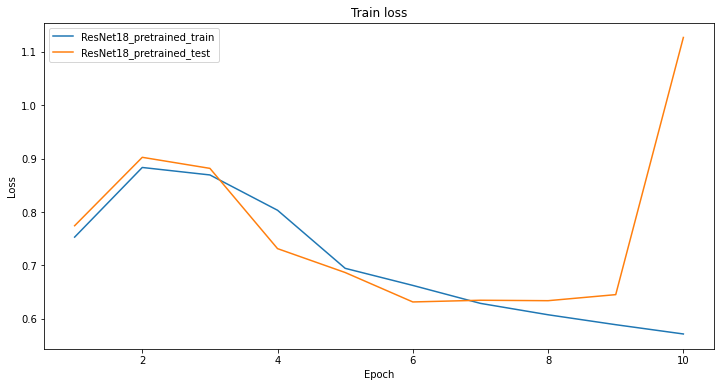

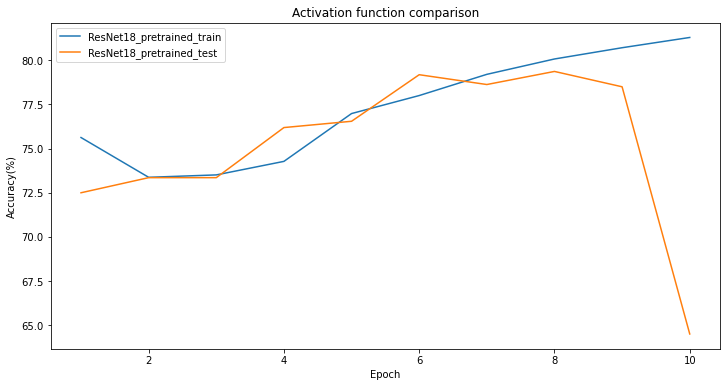

ResNet18_pretrained's best accuracy: 0.7935943060498221


In [55]:
# init_seed()

BATCH_SIZE: int = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Prepare models
# make sure the model is reproducible
NUM_CLASSES: int = 5
models = {}
# init_seed()
models["ResNet18_pretrained"] = ResNet18(NUM_CLASSES, pretrained = True, feature_extracting = False)
# init_seed()
# models["ResNet18"] = ResNet18(NUM_CLASSES, pretrained = False)

LEARNING_RATE: float = 1e-3
optimizer_fn = lambda params: torch.optim.SGD(params, lr = LEARNING_RATE, momentum = 0.9, weight_decay = 5e-4)
loss = nn.CrossEntropyLoss()

EPOCH_SIZE: int = 10
EEGNet_trainer = Trainer(loss, train_dataloader, test_dataloader)
EEGNet_trainer.train(models, optimizer_fn, EPOCH_SIZE)

In [ ]:
BATCH_SIZE: int = 512
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

LEARNING_RATE: float = 1e-3
NUM_CLASSES: int = 5
models = {
    "ResNet50_pretrained": ResNet50(NUM_CLASSES),
    "ResNet50": ResNet50(NUM_CLASSES, pretrained = False),
}
optimizer_fn = lambda params: torch.optim.SGD(params, lr = LEARNING_RATE, momentum = 0.9, weight_decay = 5e-4)
loss = nn.CrossEntropyLoss()

EPOCH_SIZE: int = 100
EEGNet_trainer = Trainer(loss, train_dataloader, test_dataloader)
EEGNet_trainer.train(models, optimizer_fn, EPOCH_SIZE)